In [12]:
from IPython.display import Markdown as md
import os
import numpy as np
import matplotlib.pyplot as plt
import ssl
import pandas as pd
import os
from datetime import datetime
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
ssl._create_default_https_context = ssl._create_unverified_context

COUNTRY = os.getenv('NB_ARGS', 'Germany')
if COUNTRY is None:
    raise RuntimeError("No country is provided by the user! NOT running!") 
md(f"# Web-based Analysis of Spread of Covid-19 for country {COUNTRY}")

# Web-based Analysis of Spread of Covid-19 for country Germany

## Introduction

Based on Reference [1], an SIR (the Spread of an Infective Disease) model for infective disease is based on the following differential equations.

${dS \over dt} = -{\beta I S \over N} $ &nbsp;&nbsp;&nbsp;(1)

${dI \over dt} = {\beta I S \over N} - {\gamma I} = ({\beta S \over N } - \gamma)I  $  &nbsp;&nbsp;&nbsp;(2)

${dR \over dt} = {\gamma I}  $  &nbsp;&nbsp;&nbsp;(3)

where
* $S$ is the initial susceptible population
* $I$ is the initial infected population
* $R$ is the initial recovered population
* $N$ is the initial sum of $S$, $I$, $R$ and will remain constants

## Estimations of the parameters

In the initial stage, since $I$ is very small, and $R$ can be assumed to be 0. so $S_0$ is very close to $N$. Therefore, it is reasonable to use the whole population for the estimation of $S_0$. $I_0$ to be 1, and $R_0$ to be 0. And, we have the following estimates.

${dS \over dt} = -{\beta I S \over N} \approx {\beta I} $  &nbsp;&nbsp;&nbsp; (4)  &nbsp;&nbsp;&nbsp; since in the beginning, S is very close to N

${dI \over dt} = {\beta I S \over N} - {\gamma I} = ({\beta S \over N } - \gamma)I = {m} I $  &nbsp;&nbsp;&nbsp; (5)  &nbsp;&nbsp;&nbsp; where m=${\beta S \over N } - \gamma $

${dR \over dt} = {\gamma I}  $   &nbsp;&nbsp;&nbsp;(6)

Due to the observation that

${dS \over dt}+{dI \over dt}+{dR \over dt}=0$

$\beta$ and $\gamma$ are directly related to the basic reproduction number
$R_0$ and typical time until recovery $T_r$ in the following formula:

$R_0={\beta \over \gamma}$

$T_r = {\gamma}^{-1}$. 


And it is well known that recovery time is more or less the same across different countries, which is about 14 days. We can get the $\gamma$ value to be 1/14 $\approx $ 0.07.

Since from equation (4), we can get 
${dI \over I} = {m dt} => {ln I(t) = ln I_0 + mt}$

So by taking the logrithm of the infected number of cases, and do a linear fit, we can have a good estimation of m. Thus, it will be easy to calculate the $\beta$.
The SIR model lies on a few assumptions:
* $R_0$ and $T_r$ is constant through the whole simulation process.
* There is no/few deaths from the disease so that $N$ is constant through the process.
* Recovered population will get immune to the spread of the disease.

In [13]:
country_population = pd.read_csv('/Users/shujie/Documents/Documents/CPT_HU/Semester6/CISC699/project/app4/website/da/world_population.csv')
# Initial value S will be the total population for that country
INIT_S = int(country_population[(country_population['Country Name']==COUNTRY) & (country_population['Series Code']=='SP.POP.TOTL')].iloc[0,-1])
INIT_I = 1
INIT_R = 0
GAMMA = 0.07 # it normally takes about 14 days for a person to recover, thus beta = 1/14 = 0.07
#based on old values, calculate new values for time change dt
def s_new(s_old, i_old, beta, n, dt):
    """
    Computes S value for the next timestep, based on
    s_old : current S value
    i_old : current I value
    beta : R0 * gamma
    n: sum of S, I and R, which is constant through the whole time
    dt : timestep
    """
    return s_old - beta * i_old * s_old / n * dt

def i_new(s_old, i_old, beta, gamma, n, dt):

    """
    Computes I value for the next timestep, based on
    i_old : current I value
    s_old : current S value
    beta : R0 * gamma
    gamma : inverse of Tr (typical time until recovery)
    n: sum of S, I and R, which is constant through the whole time
    dt : timestep
    """
    return i_old + (beta * i_old * s_old / n - gamma * i_old) * dt

def r_new(i_old, r_old, gamma, dt):
    """
    Computes R value for the next timestep, based on
    i_old : current I value
    s_old : current R value
    gamma : inverse of Tr (typical time until recovery)
    dt : timestep
    """
    return r_old + gamma * i_old * dt


# Solve the problem with iterations.
def sir_model(s_0, i_0, r_0, beta, gamma, t_n, dt):
    """
    s_0, i_0, r_0 : initial values for s, i, r
    beta : R0 * gamma
    gamma : inverse of Tr (typical time until recovery)
    t_n : final time step
    dt : timestep
    Returns four numpy arrays, s, i, r, t.
    """
  
    # Calculate # of timesteps and prepare result t array.
    num_timesteps = int(t_n / dt) + 1
    t = np.arange(start=0.0, stop=t_n+dt, step=dt)

    # Initialize result arrays.
    s = np.zeros(num_timesteps, dtype=float)
    i = np.zeros(num_timesteps, dtype=float)
    r = np.zeros(num_timesteps, dtype=float)

    # Store the initial SIR populations.
    s[0] = s_0
    i[0] = i_0
    r[0] = r_0
    n = s_0 + i_0 + r_0

    # Iterate!
    for iter in np.arange(1, num_timesteps):
        s[iter] = s_new(s_old=s[iter-1], i_old=i[iter-1], beta=beta,
                        n=n, dt=dt)
        i[iter] = i_new(s_old=s[iter-1], i_old=i[iter-1], beta=beta,
                        gamma=gamma, n=n, dt=dt)
        r[iter] = r_new(i_old=i[iter-1], r_old=r[iter-1], gamma=gamma, dt=dt)
    return s, i, r, t

def plot_series(t, series_list, series_labels, 
                xlabel, ylabel, title):
    """
    series_list : list of numpy results to plot
    series_labels : list of labels for above series_list
    xlabel, ylabel : label for x and y axes respectiely
    title : plot title
    """
    for series, label in zip(series_list, series_labels):
      plt.plot(t, series, label=label)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def calculate_beta(m, gamma):
    return m + gamma

In [14]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{}_global.csv'

confirmed_cases = pd.read_csv(url.format('confirmed'))
confirmed_cases = confirmed_cases[confirmed_cases['Country/Region'] == COUNTRY]

death_cases = pd.read_csv(url.format('deaths'))
death_cases = death_cases[death_cases['Country/Region'] == COUNTRY]              
recorvered_cases = pd.read_csv(url.format('recovered'))
recorvered_cases = recorvered_cases[recorvered_cases['Country/Region'] == COUNTRY]              
if (not len(death_cases) or not len(confirmed_cases) or not len(recorvered_cases)):
    md("No record found for provided country '{}'".format(COUNTRY))
    raise RuntimeError("No record found for provided country '{}'".format(COUNTRY))
                          
# Filter out the global covid-19 cases by targeted country
# Right now, I am choosing Feb. 28 2021 as the hard date since this is when mrna vaccination started
# '1/22/2020' is the date of the first report
start_date = '1/22/20'
end_date = '4/28/21'

confirmed = confirmed_cases.iloc[0].loc[:end_date][4:]
deaths = death_cases.iloc[0].loc[:end_date][4:]
recovered = recorvered_cases.iloc[0].loc[:end_date][4:]

infected = confirmed - deaths - recovered

DT = 1
TN = len(confirmed) - 1

# R0 = BETA/GAMMA
# TR = 1.0/GAMMA

df = pd.DataFrame({
    'Infected': infected.values,
    'Recoverd': recovered.values,
}, index=infected.index)

In [15]:
df['Log_Infected']=np.log10(df['Infected'].astype(int).replace(0, np.nan))
df = df.rename_axis('time').reset_index()
df_no_na = df[df['Log_Infected'].notna()]
df_no_na = df_no_na.rename_axis('days_elapse').reset_index()
result = sm.ols(formula="Log_Infected ~ days_elapse", data=df_no_na[:100]).fit()
result.params
m = result.params['days_elapse']
BETA = calculate_beta(m, GAMMA)

In [16]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Log_Infected   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     450.7
Date:                Wed, 17 Nov 2021   Prob (F-statistic):           1.95e-38
Time:                        22:37:26   Log-Likelihood:                -109.14
No. Observations:                 100   AIC:                             222.3
Df Residuals:                      98   BIC:                             227.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1775      0.156      1.141      0.257      -0.131       0.486
days_elapse     0.0535      0.003     21.230      0.000       0.049       0.059
==============================================================================
Omnibus:                        6.254   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                5.401
Skew:                          -0.482   Prob(JB):                       0.0672
Kurtosis:                       2.394   Cond. No.                         132.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

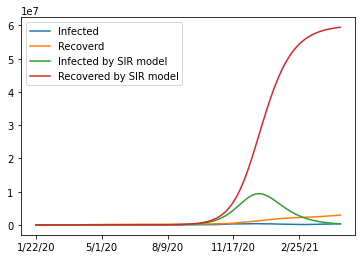

In [17]:
s, i, r, t = sir_model(s_0=INIT_S, i_0=INIT_I, r_0=INIT_R, 
                         beta=BETA, gamma=GAMMA, t_n=TN, dt=DT)

df_model = pd.DataFrame({
            'Infected': infected.values,
            'Recoverd': recovered.values,
            'Infected by SIR model': i,
            'Recovered by SIR model': r
        }, index=infected.index)
df_model.plot()

Based on the graph above, we can see that:
* Actual Infected population doesn't match well with the SIR model.
* Actual recovered population curve comes later than expected but becomes a lot sharper than expected.
* The current model is not good enough for give country. A lot more modifications in the algorithm is required.


# References
[1] A Simple Example of a Mathematical Model: The Spread of an Infectious Disease. *Torkel Loman*, https://www.pathsense.eu/simple-example-mathematical-model-spread-infectious-disease/

[2] Data Source: Center for Systems Science and Engineering (CSSE) at Johns Hopkins University, https://github.com/CSSEGISandData
